In [4]:
# import libraries
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import s3fs
from shapely.geometry import Point, Polygon
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt
import contextily as ctx

#from qaqc_utils import *

%matplotlib inline

In [5]:
# Helper function for plotting
def latlon_to_mercator_cartopy(lat, lon):
    proj_latlon = CRS('EPSG:4326')
    proj_mercator = CRS('EPSG:3857')
    
    # Transform the coordinates
    transformer = Transformer.from_crs(proj_latlon, proj_mercator, always_xy=True)
    x,y = transformer.transform(lon, lat)
    
    return x, y

# Shapefile of CA counties, for subsetting for a specific area
ca_counties = gpd.read_file("s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp" )

In [6]:
# Read in all stations
df_all = pd.read_csv("s3://wecc-historical-wx/2_clean_wx/temp_clean_all_station_list.csv")

# Subset for cleaned stations (Y flag)
df_clean = df_all.loc[df_all['cleaned'] == 'Y']
df_clean.head(5)

,Unnamed: 0,era-id,latitude,longitude,elevation,start-date,end-date,cleaned,time_cleaned,network,...,pr_nobs,pr_5min_nobs,pr_1h_nobs,pr_24h_nobs,pr_localmid_nobs,hurs_nobs,sfcwind_nobs,sfcwind_dir_nobs,rsds_nobs,total_nobs
0,0,ASOSAWOS_72681024131,43.567,-116.241,860.4504,1931-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-06 23:44:42+00:00,ASOSAWOS,...,400786.0,0.0,0.0,0.0,0.0,0.0,444433.0,379116.0,87216.0,470754.0
1,1,ASOSAWOS_72774024135,45.964,-112.501,1677.9240,2005-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:34:21+00:00,ASOSAWOS,...,131484.0,0.0,0.0,0.0,0.0,0.0,177652.0,121517.0,0.0,183432.0
2,2,ASOSAWOS_72571094025,40.481,-107.218,2011.6800,2005-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:44:41+00:00,ASOSAWOS,...,63539.0,0.0,0.0,0.0,0.0,0.0,371625.0,324697.0,0.0,374482.0
3,3,ASOSAWOS_72687600387,44.400,-118.967,1127.1504,2005-01-03 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:48:37+00:00,ASOSAWOS,...,14009.0,0.0,0.0,0.0,0.0,0.0,402892.0,320886.0,0.0,408311.0
4,4,ASOSAWOS_72020200118,45.417,-123.817,11.2776,2005-01-03 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:46:35+00:00,ASOSAWOS,...,53279.0,0.0,0.0,0.0,0.0,0.0,397127.0,220449.0,0.0,401832.0


#### Example of subsetting for a variable + region
Looking at stations in the Santa Clara region for precipitation sensors

In [7]:
# Pick specific county
target_county = ca_counties[ca_counties['NAME'] == 'Santa Clara']

In [8]:
# Identify stations with precipitation sensors, looking for sensors with more than 5 observations to avoid stations that have a single observation
df_clean_pr = df_clean.loc[(df_clean[['pr_nobs', 'pr_5min_nobs', 'pr_1h_nobs', 'pr_24h_nobs', 'pr_localmid_nobs']] > 5).any(axis=1)]
df_clean_pr

# Option to output the subsetted stations with precip
df_clean_pr.to_csv('histobs_stns_all_precip.csv')

In [9]:
# Set up a map
geometry = [Point(latlon_to_mercator_cartopy(lat,lon)) for lat,lon in zip (df_clean.latitude, df_clean.longitude)]
pr_stns = gpd.GeoDataFrame(df_clean, geometry=geometry).set_crs(crs="EPSG:3857", allow_override=True) # adding geometry column
pr_stns = gpd.overlay(pr_stns, target_county, how="intersection") # subsetting for stations within county boundaries
print(f'Number of stations: {len(pr_stns)}')

Number of stations: 251


In [10]:
valley_water_stations = pr_stns[pr_stns['network']=='VALLEYWATER']
print(len(valley_water_stations))

45


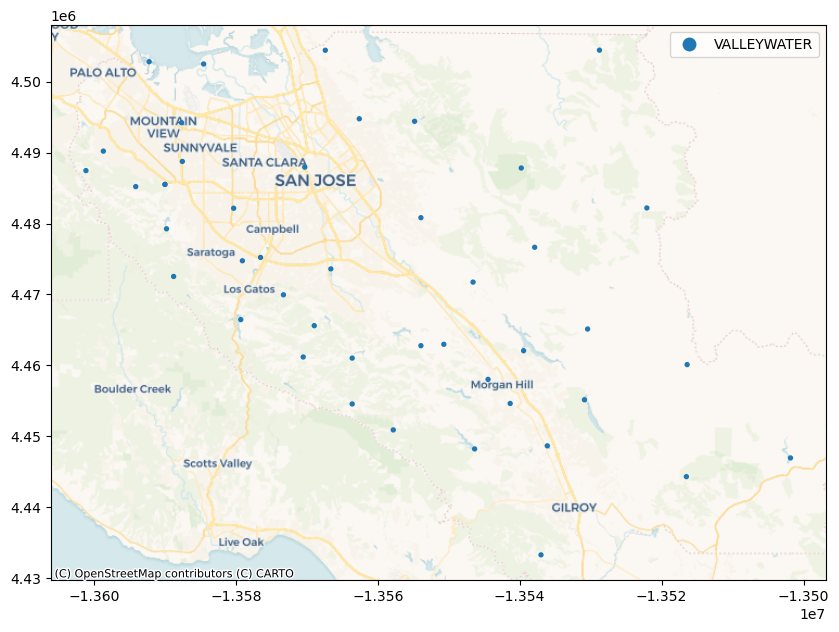

In [11]:
# Mapping
ax = valley_water_stations.plot(column='network', markersize=8, legend=True, figsize=(10,10))
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

# Also, can use your geodataframe and .explore() to zoom around
## pr_stns.explore()

## Pull all Valley Water QA/QC'd data

In [12]:
# Authenticate using AWS credentials
s3 = s3fs.S3FileSystem(anon=False)

# Define the correct parent S3 directory
parent_s3_path = "wecc-historical-wx/3_qaqc_wx/VALLEYWATER/"

# List available Zarr folders (fixing the duplicated path issue)
zarr_folders = [f"s3://{path}" for path in s3.ls(parent_s3_path) if path.endswith(".zarr")]

print("Found Zarr datasets:", zarr_folders)

# Read each Zarr dataset
datasets = {}

for zarr_path in zarr_folders:
    try:
        ds = xr.open_zarr(zarr_path, storage_options={"s3": {"anon": False}})
        datasets[zarr_path] = ds
        print(f"Loaded: {zarr_path}")
    except Exception as e:
        print(f"Error loading {zarr_path}: {e}")


Found Zarr datasets: ['s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6001.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6004.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6008.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6015.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6016.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6017.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6018.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6021.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6023.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6034.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6036.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6041.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6044.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWA

In [13]:
for zarr_path, ds in datasets.items():
    print(f"Variables in {zarr_path}:")
    print(list(ds.data_vars))  # List of data variables (columns)
    print("\nMetadata:")
    print(ds.attrs)  # Prints dataset-level metadata
    print("\n" + "="*50 + "\n")  # Separator for readability


Variables in s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6001.zarr:
['anemometer_height_m', 'elevation', 'elevation_eraqc', 'lat', 'lon', 'pr_15min', 'pr_15min_eraqc', 'raw_qc', 'thermometer_height_m']

Metadata:
{'Networks': 'VALLEYWATER', 'comment': 'Intermediate data product: may not have been subject to any cleaning or QA/QC processing \nAn intermediate data product: subject to cleaning but may not be subject to full QA/QC processing.', 'disclaimer': "This document was prepared as a result of work funded by the Santa Clara Valley Water District. It does not necessarily represent the views of the Santa Clara Valley Water District or its employees. Neither the Santa Clara Valley Water District, nor it's employees, contractors, or subcontractors makes any warranty, express or implied, or assumes any legal liability for the information in this document; nor does any party represent that the use of this information will not infringe upon privately owned rights. This docume

In [36]:
import pandas as pd
import xarray as xr
import s3fs

# Authenticate using AWS credentials
s3 = s3fs.S3FileSystem(anon=False)

# Define the correct parent S3 directory
parent_s3_path = "wecc-historical-wx/3_qaqc_wx/VALLEYWATER/"

# List available Zarr folders
zarr_folders = [f"s3://{path}" for path in s3.ls(parent_s3_path) if path.endswith(".zarr")]

print("Found Zarr datasets:", zarr_folders)

# Read each Zarr dataset
datasets = {}

for zarr_path in zarr_folders:
    try:
        ds = xr.open_zarr(zarr_path, storage_options={"s3": {"anon": False}})
        datasets[zarr_path] = ds
        print(f"Loaded: {zarr_path}")
    except Exception as e:
        print(f"Error loading {zarr_path}: {e}")

# List to store rows with max 'pr_15min' values
max_pr_rows = []

# Iterate through datasets
for zarr_path, ds in datasets.items():
    if "station" in ds.dims and "time" in ds.dims:
        # Get station IDs
        station_ids = ds["station"].values

        for i, station_id in enumerate(station_ids):
            # Convert station data to a dataframe
            station_data = ds.isel(station=i).to_dataframe()

            # Find the row with the max 'pr_15min' value
            max_idx = station_data["pr_15min"].idxmax()
            max_row = station_data.loc[max_idx].copy()

            # Add station ID and file path info
            max_row["station"] = station_id
            max_row["zarr_path"] = zarr_path
            
            # Append to list
            max_pr_rows.append(max_row)

# Convert list of max rows to DataFrame
max_pr_df = pd.DataFrame(max_pr_rows)

# Reset index for clean output
max_pr_df = max_pr_df.reset_index()

# Display the final DataFrame
print(max_pr_df)


Found Zarr datasets: ['s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6001.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6004.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6008.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6015.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6016.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6017.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6018.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6021.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6023.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6034.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6036.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6041.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6044.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWA

In [14]:
valley_water_stations_geometries = valley_water_stations[['era-id', 'geometry']]


In [15]:
# Rename 'era-id' to 'station' in valley_water_stations
valley_water_stations = valley_water_stations_geometries.rename(columns={'era-id': 'station'})

def merge_with_geometry(ds):
    """Converts an xarray dataset to a DataFrame and merges with station geometries."""
    df = ds.to_dataframe().reset_index()  # Convert dataset to DataFrame
    
    if 'station' not in df.columns:
        print("Warning: No 'station' column in dataset. Check your dataset structure!")
        return None

    # Merge with valley_water_stations to add geometry
    merged_df = df.merge(valley_water_stations[['station', 'geometry']], on='station', how='left')

    return merged_df

# Apply function to all datasets
merged_datasets = {zarr_path: merge_with_geometry(ds) for zarr_path, ds in datasets.items()}


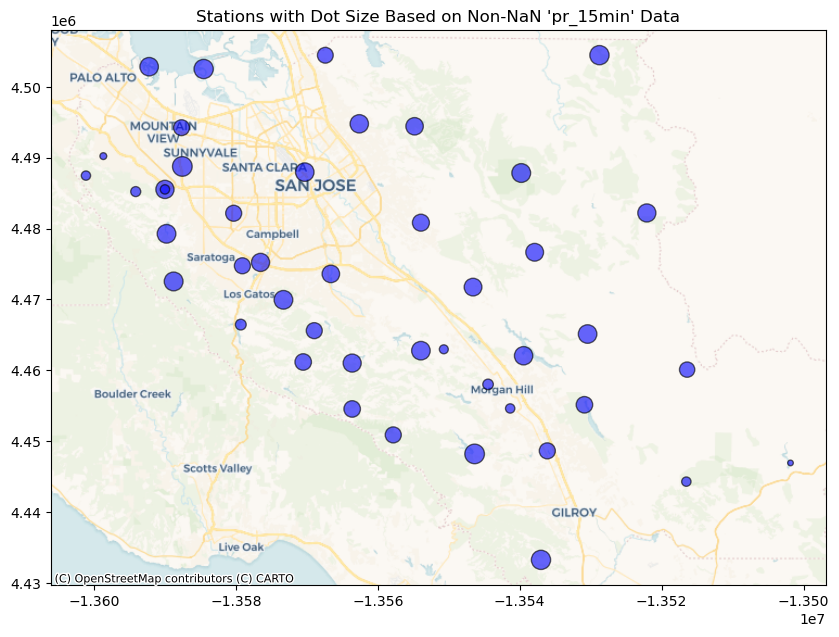

In [16]:
# Create a new DataFrame to store station data with non-NaN counts
station_data_list = []

for zarr_path, df in merged_datasets.items():
    # Count non-NaN values in 'pr_15min' for each station
    non_nan_counts = df.groupby('station')['pr_15min'].count().reset_index()
    non_nan_counts.rename(columns={'pr_15min': 'valid_pr_15min_count'}, inplace=True)

    # Merge with station geometries
    station_data = valley_water_stations[['station', 'geometry']].merge(non_nan_counts, on='station', how='left')

    station_data_list.append(station_data)

# Combine all station datasets
all_stations_df = pd.concat(station_data_list, ignore_index=True)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(all_stations_df, geometry='geometry', crs="EPSG:3857")

# Normalize size (optional) for better scaling
gdf['size'] = gdf['valid_pr_15min_count'] / gdf['valid_pr_15min_count'].max() * 200  # Adjust multiplier as needed

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, markersize=gdf['size'], alpha=0.6, color='blue', edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

plt.title("Stations with Dot Size Based on Non-NaN 'pr_15min' Data")
plt.show()


In [17]:
station_data_list

[             station                           geometry  valid_pr_15min_count
 0   VALLEYWATER_6021  POINT (-13530884.106 4455162.409)                   NaN
 1   VALLEYWATER_6143  POINT (-13541348.138 4454645.907)                   NaN
 2   VALLEYWATER_6044  POINT (-13563612.036 4454576.111)                   NaN
 3   VALLEYWATER_6069  POINT (-13570513.845 4461194.795)                   NaN
 4   VALLEYWATER_6123  POINT (-13568955.372 4465609.557)                   NaN
 5   VALLEYWATER_6144  POINT (-13589994.756 4485512.894)                   NaN
 6   VALLEYWATER_6135  POINT (-13557823.423 4450919.460)                   NaN
 7   VALLEYWATER_6134  POINT (-13536116.122 4448673.061)                   NaN
 8   VALLEYWATER_6079  POINT (-13579085.445 4474752.310)                   NaN
 9   VALLEYWATER_6008  POINT (-13528769.036 4504430.067)                   NaN
 10  VALLEYWATER_6001  POINT (-13566617.662 4473605.536)             1399082.0
 11  VALLEYWATER_6016  POINT (-13584540.100 4502480.

In [31]:
station_id = "VALLEYWATER_6150  "  # Replace with the station ID you want to check

# Pick one merged dataset
sample_zarr_path, sample_df = next(iter(merged_datasets.items()))  # Get first dataset

# Filter for the specific station
station_data = sample_df[sample_df['station'] == station_id]

# Display unique values for specific columns
print("Unique values for 'pr_15min_eraqc':", station_data['pr_15min_eraqc'].unique())
print("Unique values for 'pr_15min':", station_data['pr_15min'].unique())
print("Unique values for 'raw_qc':", station_data['raw_qc'].unique())


Unique values for 'pr_15min_eraqc': []
Unique values for 'pr_15min': []
Unique values for 'raw_qc': []


In [19]:
# Sort by 'pr_15min' in descending order and display the top rows
top_pr_15min_rows = station_data.sort_values(by='pr_15min', ascending=False).head()

# Display the result
print(top_pr_15min_rows)


Empty DataFrame
Columns: [station, time, anemometer_height_m, elevation, elevation_eraqc, lat, lon, pr_15min, pr_15min_eraqc, raw_qc, thermometer_height_m, geometry]
Index: []


## Merge all stations precipitation data together, creating a single df

In [20]:
# Create an empty list to store DataFrames from each station
station_dfs = []

num_stations = 50  # Process a subset first

for zarr_path, ds in datasets.items():
    if "station" in ds.dims and "time" in ds.dims:
        # Get station IDs (subset if needed)
        station_ids = ds["station"].values[:num_stations]

        for i, station_id in enumerate(station_ids):
            # Extract 'pr_15min' for this station
            station_data = ds.isel(station=i)[["pr_15min"]].to_dataframe()

            # Drop 'station' column if it exists
            if "station" in station_data.columns:
                station_data = station_data.drop(columns=["station"])

            # Rename columns to include the station ID
            station_data = station_data.rename(columns={
                "pr_15min": f"pr_15min_{station_id}"
            })

            # Append to list
            station_dfs.append(station_data)

# Merge all station DataFrames on 'time'
merged_df = pd.concat(station_dfs, axis=1)

# Reset index to make 'time' a column
merged_df = merged_df.reset_index()

# Display result
print(len(merged_df))
print(merged_df.head(10))

1772774
                 time  pr_15min_VALLEYWATER_6001  pr_15min_VALLEYWATER_6004  \
0 1974-06-21 08:15:00                        NaN                        NaN   
1 1974-06-21 08:30:00                        NaN                        NaN   
2 1974-06-21 08:45:00                        NaN                        NaN   
3 1974-06-21 09:00:00                        NaN                        NaN   
4 1974-06-21 09:15:00                        NaN                        NaN   
5 1974-06-21 09:30:00                        NaN                        NaN   
6 1974-06-21 09:45:00                        NaN                        NaN   
7 1974-06-21 10:00:00                        NaN                        NaN   
8 1974-06-21 10:15:00                        NaN                        NaN   
9 1974-06-21 10:30:00                        NaN                        NaN   

   pr_15min_VALLEYWATER_6008  pr_15min_VALLEYWATER_6015  \
0                        NaN                        NaN   
1   

In [33]:
import pandas as pd

# Dictionary to store max 'pr_15min' rows for each station
max_pr_rows = []

for zarr_path, ds in datasets.items():
    if "station" in ds.dims and "time" in ds.dims:
        # Get station IDs (subset if needed)
        station_ids = ds["station"].values[:num_stations]

        for i, station_id in enumerate(station_ids):
            # Extract 'pr_15min' for this station
            station_data = ds.isel(station=i)[["pr_15min"]].to_dataframe()

            # Drop 'station' column if it exists
            if "station" in station_data.columns:
                station_data = station_data.drop(columns=["station"])

            # Rename columns to include the station ID
            station_data = station_data.rename(columns={"pr_15min": f"pr_15min_{station_id}"})

            # Find the row with the max 'pr_15min' value for this station
            max_row = station_data.loc[station_data[f"pr_15min_{station_id}"].idxmax()]
            max_row["station"] = station_id  # Add station info
            max_row["zarr_path"] = zarr_path  # Add file path info
            
            max_pr_rows.append(max_row)

# Convert list of max rows to DataFrame
max_pr_df = pd.DataFrame(max_pr_rows)

# Reset index for clean output
max_pr_df = max_pr_df.reset_index(drop=True)

# Display the final DataFrame with max pr_15min values for each station
print(max_pr_df)


    pr_15min_VALLEYWATER_6001           station  \
0                   11.000003  VALLEYWATER_6001   
1                         NaN  VALLEYWATER_6004   
2                         NaN  VALLEYWATER_6008   
3                         NaN  VALLEYWATER_6015   
4                         NaN  VALLEYWATER_6016   
5                         NaN  VALLEYWATER_6017   
6                         NaN  VALLEYWATER_6018   
7                         NaN  VALLEYWATER_6021   
8                         NaN  VALLEYWATER_6023   
9                         NaN  VALLEYWATER_6034   
10                        NaN  VALLEYWATER_6036   
11                        NaN  VALLEYWATER_6041   
12                        NaN  VALLEYWATER_6044   
13                        NaN  VALLEYWATER_6048   
14                        NaN  VALLEYWATER_6053   
15                        NaN  VALLEYWATER_6067   
16                        NaN  VALLEYWATER_6069   
17                        NaN  VALLEYWATER_6077   
18                        NaN  

In [21]:
# Replace zeros with NaN to ignore them in calculations
merged_df_no_zeros = merged_df.replace(0, np.nan)

# Compute descriptive statistics excluding zeros
print(merged_df_no_zeros.describe())


                                time  pr_15min_VALLEYWATER_6001  \
count                        1772774               11014.000000   
mean   1999-10-01 12:52:29.999998336                   1.290675   
min              1974-06-21 08:15:00                   0.762000   
25%              1987-02-09 22:33:45                   1.000001   
50%              1999-10-01 12:52:30                   1.000001   
75%              2012-05-22 03:11:15                   1.016000   
max              2025-01-10 17:30:00                  11.000003   
std                              NaN                   0.669909   

       pr_15min_VALLEYWATER_6004  pr_15min_VALLEYWATER_6008  \
count               21282.000000               13120.000000   
mean                    1.549128                   1.394324   
min                     0.762000                   1.000000   
25%                     1.000001                   1.000001   
50%                     1.016000                   1.000001   
75%               

In [22]:
# Summary statistics for all station columns
print(merged_df.describe())


                                time  pr_15min_VALLEYWATER_6001  \
count                        1772774               1.399082e+06   
mean   1999-10-01 12:52:29.999998336               1.016059e-02   
min              1974-06-21 08:15:00               0.000000e+00   
25%              1987-02-09 22:33:45               0.000000e+00   
50%              1999-10-01 12:52:30               0.000000e+00   
75%              2012-05-22 03:11:15               0.000000e+00   
max              2025-01-10 17:30:00               1.100000e+01   
std                              NaN               1.286211e-01   

       pr_15min_VALLEYWATER_6004  pr_15min_VALLEYWATER_6008  \
count               1.489554e+06               1.690087e+06   
mean                2.213317e-02               1.082401e-02   
min                 0.000000e+00               0.000000e+00   
25%                 0.000000e+00               0.000000e+00   
50%                 0.000000e+00               0.000000e+00   
75%               

In [23]:
# Pick two random stations
station1, station2 = merged_df.columns[1], merged_df.columns[21]

# Compute absolute difference
diff = (merged_df[station1] - merged_df[station2]).abs()

# Print summary of differences
print(f"Difference between {station1} and {station2}:")
print(diff.describe())


Difference between pr_15min_VALLEYWATER_6001 and pr_15min_VALLEYWATER_6099:
count    1.391411e+06
mean     1.425576e-02
std      1.604487e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.499993e+01
dtype: float64


## Pull Santa Clara Watershed Data from Valley Water

In [24]:
santa_clara_watershed_data = 's3://wecc-historical-wx/0_maps/Santa_Clara_County_Watersheds/'

In [27]:
santa_clara_watersheds = gpd.read_file(santa_clara_watershed_data)


In [28]:
santa_clara_watersheds

,NAME,LABEL,OBJECTID,GLOBALID,SHAPE_Leng,SHAPE_Area,geometry
0,Coyote,C,1,{6268E9A1-0664-48FD-8C86-B224ED64C1E1},753785.984578,9.732284e+09,"POLYGON ((-13566119.396 4506803.166, -13566095..."
1,San Francisquito,G,2,{A647520D-99CE-4166-BA3D-63EDFD01C92D},250721.244582,1.194279e+09,"POLYGON ((-13594649.955 4503662.062, -13594625..."
2,Adobe,A,3,{5F5A4B06-F0B6-45E5-9CEF-45CC500C334D},157319.495940,7.886900e+08,"POLYGON ((-13599335.436 4500846.459, -13599198..."
3,Sunnyvale West,J,4,{5EB54187-D734-4887-9B7B-98E13B33EA93},97896.142437,2.115624e+08,"POLYGON ((-13586434.518 4498989.934, -13586426..."
4,Guadalupe River,D,5,{2594D717-CEA4-452A-88CA-AE24888DD096},440281.616085,4.744216e+09,"POLYGON ((-13573384.073 4498160.715, -13573384..."
5,Permanente,F,6,{1DC9D53B-9919-4759-979A-447B8BBCBB5C},218508.370955,1.297324e+09,"POLYGON ((-13590744.616 4497493.220, -13590303..."
6,Calabazas,B,7,{B699E8B5-85F0-4032-9898-BF29D9FCC65B},182572.648947,5.821990e+08,"POLYGON ((-13579372.809 4496853.227, -13579371..."
7,San Tomas,H,8,{EC964C23-F585-4C79-8AC9-F126010AAD03},251476.318090,1.249336e+09,"POLYGON ((-13578488.903 4496626.629, -13578489..."
8,Sunnyvale East,I,9,{23DE2AB9-EF5B-4373-907E-709D0934FA60},109742.279477,1.984750e+08,"POLYGON ((-13581101.630 4496838.080, -13581022..."
9,Llagas,E,10,{C7E4C6DA-21BE-45F2-918B-D8F18B792CB0},377812.410455,2.817704e+09,"POLYGON ((-13541158.978 4461988.677, -13541469..."


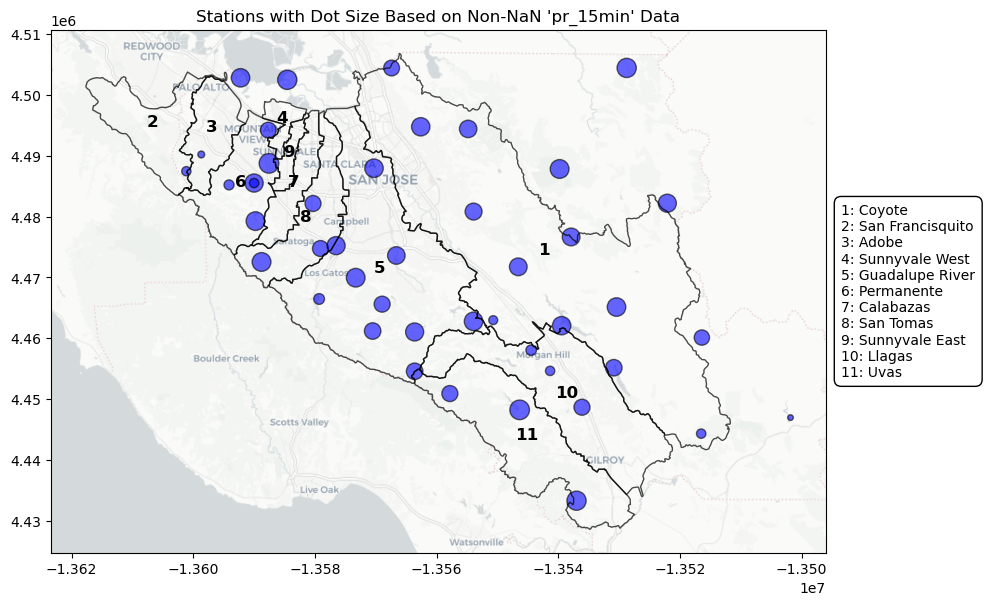

In [29]:
# Create a new DataFrame to store station data with non-NaN counts
station_data_list = []

for zarr_path, df in merged_datasets.items():
    # Count non-NaN values in 'pr_15min' for each station
    non_nan_counts = df.groupby('station')['pr_15min'].count().reset_index()
    non_nan_counts.rename(columns={'pr_15min': 'valid_pr_15min_count'}, inplace=True)

    # Merge with station geometries
    station_data = valley_water_stations[['station', 'geometry']].merge(non_nan_counts, on='station', how='left')

    station_data_list.append(station_data)

# Ensure we have valid station data before concatenation
if station_data_list:
    all_stations_df = pd.concat(station_data_list, ignore_index=True)
else:
    raise ValueError("No valid station data to concatenate!")

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(all_stations_df, geometry='geometry', crs="EPSG:3857")

# Normalize size for visualization
gdf['size'] = gdf['valid_pr_15min_count'] / gdf['valid_pr_15min_count'].max() * 200  # Adjust scaling factor

# ---- FIXED WATERSHED LABELING ----
# Ensure watershed geometries are valid before calculating centroids
santa_clara_watersheds = santa_clara_watersheds.dropna(subset=['geometry'])
santa_clara_watersheds['geometry'] = santa_clara_watersheds.geometry.buffer(0)

# Assign numeric labels to watersheds
santa_clara_watersheds['watershed_id'] = range(1, len(santa_clara_watersheds) + 1)

# Compute watershed centroids
santa_clara_watersheds['centroid'] = santa_clara_watersheds.geometry.centroid

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot stations with size-based markers
gdf.plot(ax=ax, markersize=gdf['size'], alpha=0.6, color='blue', edgecolor='black', label="Stations")

# Plot watersheds with boundaries
santa_clara_watersheds.plot(ax=ax, color='none', edgecolor='black', linewidth=1, alpha=0.7)

# Label watersheds with numeric IDs at centroid
for _, row in santa_clara_watersheds.iterrows():
    plt.text(row['centroid'].x, row['centroid'].y, str(row['watershed_id']), 
             fontsize=12, ha='center', color='black', weight='bold')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)

# Create legend for watershed numbers
watershed_legend = "\n".join([f"{row['watershed_id']}: {row['NAME']}" for _, row in santa_clara_watersheds.iterrows()])
plt.annotate(watershed_legend, xy=(1.02, 0.5), xycoords='axes fraction', ha='left', va='center', 
             fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Formatting
plt.title("Stations with Dot Size Based on Non-NaN 'pr_15min' Data")
plt.show()
